In [1]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

# fetch dataset
polish_companies_bankruptcy = fetch_ucirepo(id=365)

# data (as pandas dataframes)
X = polish_companies_bankruptcy.data.features
y = polish_companies_bankruptcy.data.targets

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate, cross_val_score

import warnings
warnings.filterwarnings('ignore')

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from imblearn.over_sampling import BorderlineSMOTE
from collections import Counter
from sklearn.decomposition import PCA

In [3]:
df = pd.concat([X, y], axis=1)

In [4]:
polish_df = df.copy()
polish_df.head()

,year,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,A56,A57,A58,A59,A60,A61,A62,A63,A64,class
0,1,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,0
1,1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,0
2,1,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,0
3,1,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,0
4,1,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,0


In [5]:
print(polish_df.shape)

(43405, 66)


In [6]:
print(polish_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43405 entries, 0 to 43404
Data columns (total 66 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    43405 non-null  int64  
 1   A1      43397 non-null  float64
 2   A2      43397 non-null  float64
 3   A3      43397 non-null  float64
 4   A4      43271 non-null  float64
 5   A5      43316 non-null  float64
 6   A6      43397 non-null  float64
 7   A7      43397 non-null  float64
 8   A8      43311 non-null  float64
 9   A9      43396 non-null  float64
 10  A10     43397 non-null  float64
 11  A11     43361 non-null  float64
 12  A12     43271 non-null  float64
 13  A13     43278 non-null  float64
 14  A14     43397 non-null  float64
 15  A15     43369 non-null  float64
 16  A16     43310 non-null  float64
 17  A17     43311 non-null  float64
 18  A18     43397 non-null  float64
 19  A19     43277 non-null  float64
 20  A20     43278 non-null  float64
 21  A21     37551 non-null  float64
 22

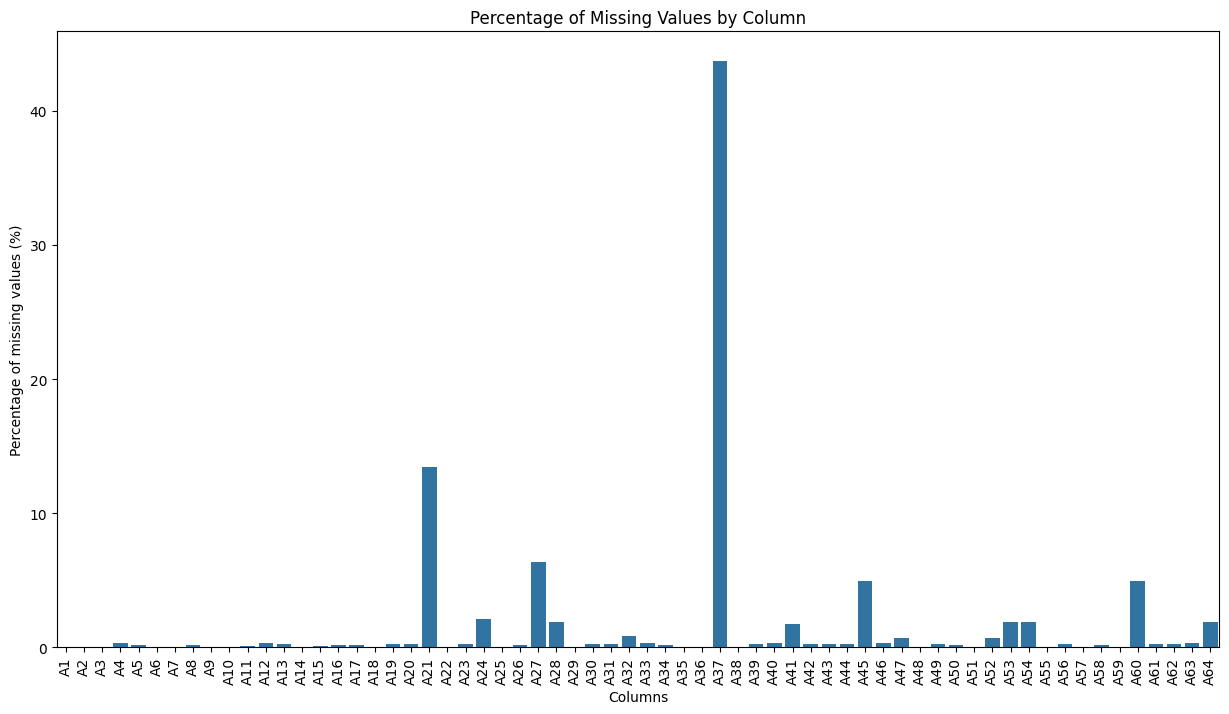

In [7]:
def plot_missing_data(df):
    # Calculate the percentage of missing values for each column
    missing_values_percent = df.isnull().mean() * 100

    # Filter to include only columns with missing data
    missing_values_filtered = missing_values_percent[missing_values_percent > 0]

    # Create a bar plot for missing value percentages
    plt.figure(figsize=(15, 8))
    sns.barplot(x=missing_values_filtered.index, y=missing_values_filtered.values)
    plt.ylabel('Percentage of missing values (%)')
    plt.xlabel('Columns')
    plt.title('Percentage of Missing Values by Column')
    plt.xticks(rotation=90)  # Rotate labels to make them readable
    plt.show()

plot_missing_data(polish_df)

In [8]:
def load_and_impute_data(df):
    """Load the data and impute missing values using mean and median imputation.
    Args:
        df (pd.DataFrame): DataFrame containing the data.
    Returns:
        pd.DataFrame: DataFrame containing the imputed data.
    """

    # Create imputers for mean and median
    mean_imputer = SimpleImputer(strategy='mean')
    median_imputer = SimpleImputer(strategy='median')

    # Determine skewness and choose appropriate imputation methods
    skewness = df.skew().abs()
    mean_columns = skewness[skewness < 0.5].index.tolist()
    median_columns = skewness[skewness >= 0.5].index.tolist()

    # Applying the imputers
    df[mean_columns] = mean_imputer.fit_transform(df[mean_columns])
    df[median_columns] = median_imputer.fit_transform(df[median_columns])

    return df

In [9]:
polish_new = load_and_impute_data(polish_df)

In [10]:
del polish_new['year']

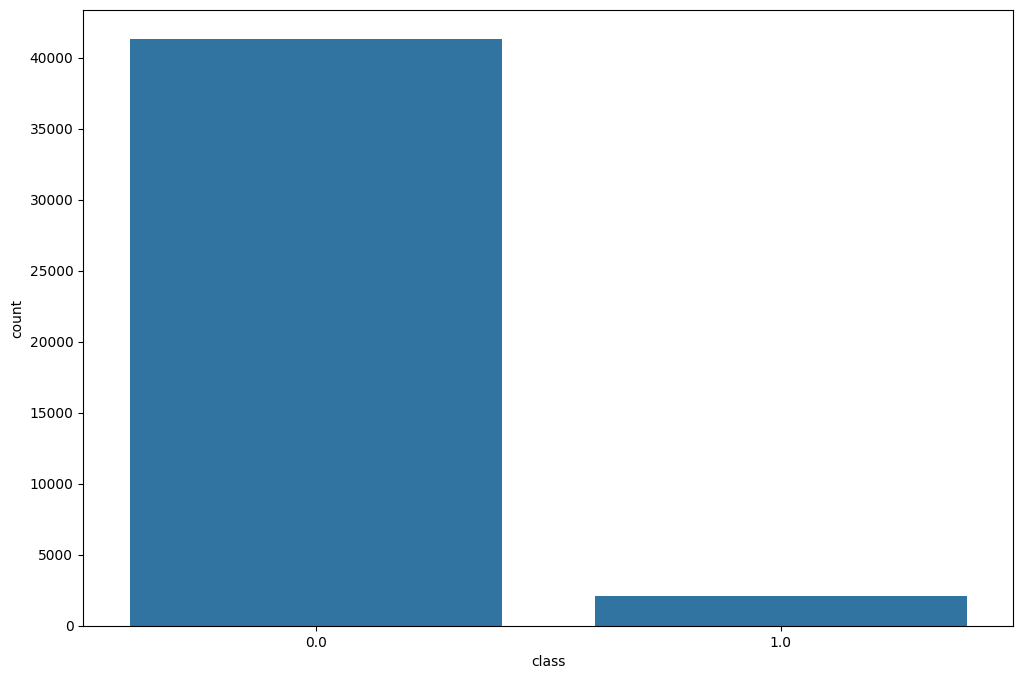

In [11]:
plt.figure(figsize=(12, 8))
bar_plot = sns.countplot(x=polish_new['class'])

In [12]:
X = polish_new.drop('class',axis=1)
y = polish_new['class']

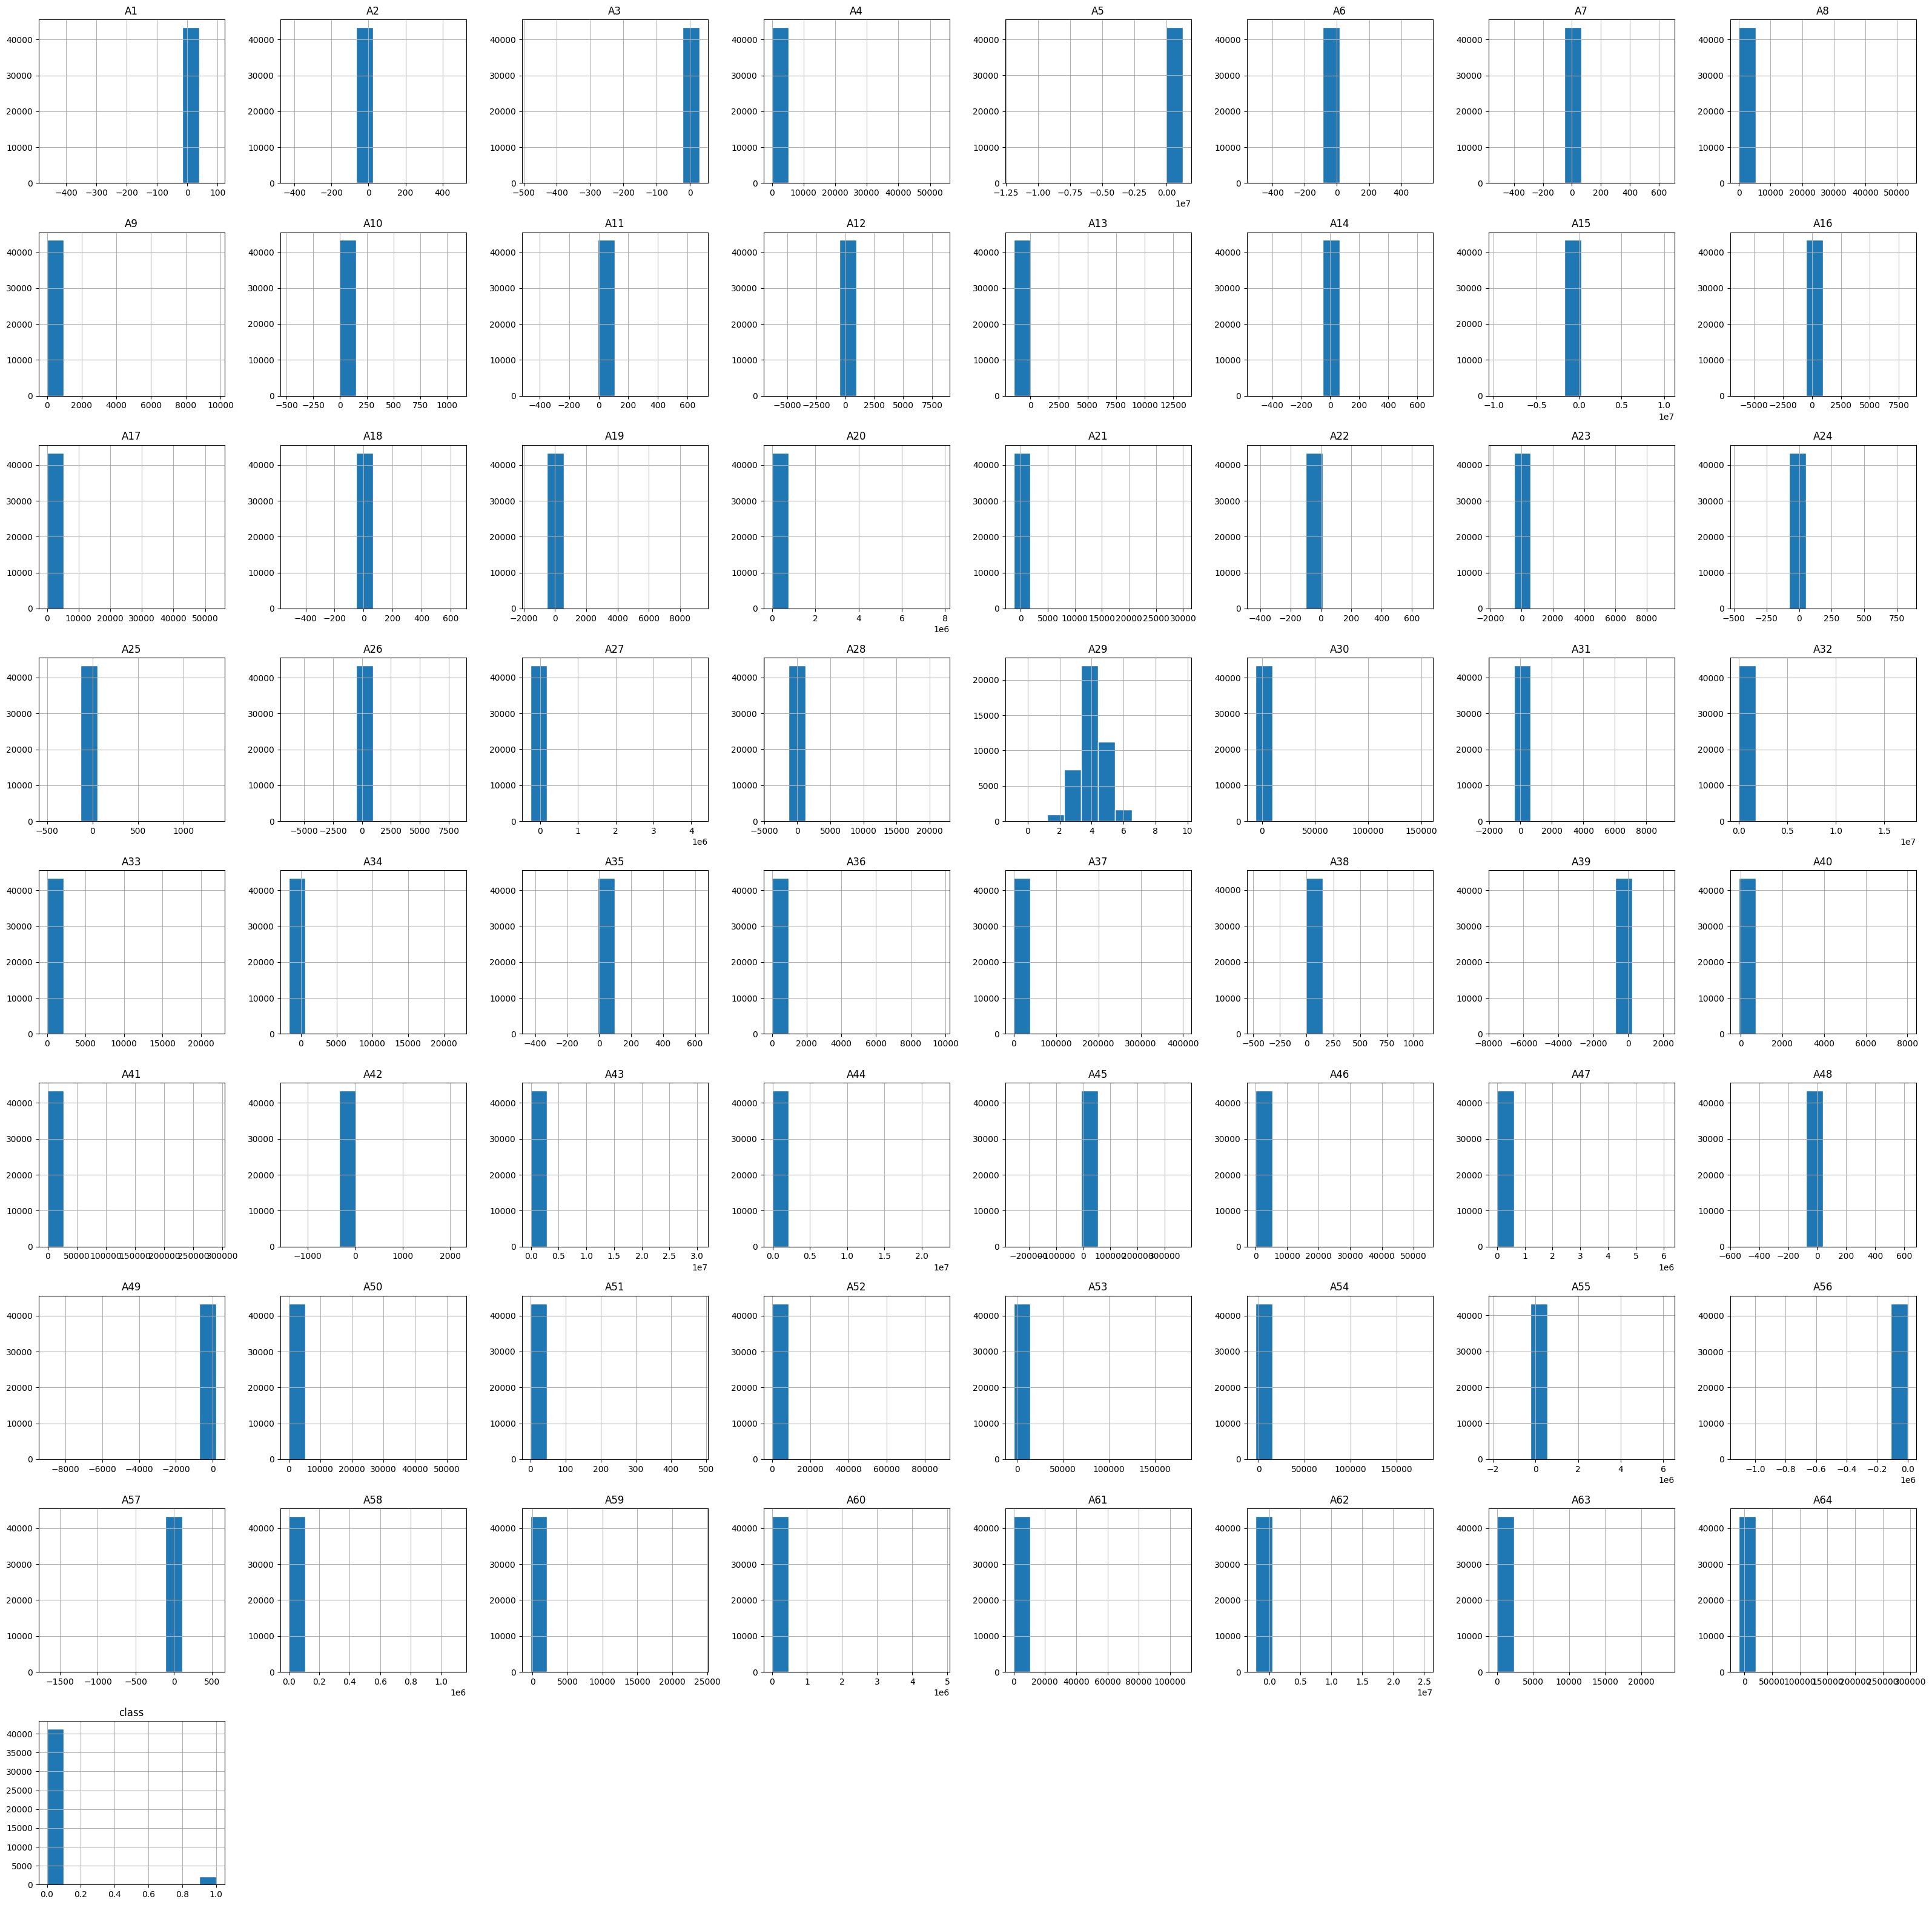

In [13]:
polish_new.hist(figsize=(40,40), edgecolor='white')
plt.show()

In [14]:
# perform some resampling
smote = BorderlineSMOTE()
X, y = smote.fit_resample(X, y)
print("Final dimensions of target label classes:", Counter(y))

Final dimensions of target label classes: Counter({0.0: 41314, 1.0: 41314})


In [15]:
# 80-20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42,stratify=y)
scaler = StandardScaler()
X_train_pca = scaler.fit_transform(X_train)
X_test_pca = scaler.transform(X_test)

# Applying PCA
pca = PCA(n_components=0.95)
X_train_scaled = pca.fit_transform(X_train_pca)
X_test_scaled = pca.transform(X_test_pca)

In [16]:
# Train decision tree with information gain
clf_entropy = DecisionTreeClassifier(criterion='entropy', random_state=42)
clf_entropy.fit(X_train_scaled, y_train)

# Predict and evaluate
y_train_pred_entropy = clf_entropy.predict(X_train_scaled)
y_test_pred_entropy = clf_entropy.predict(X_test_scaled)

metrics = {
    'Training Error': 1 - accuracy_score(y_train, y_train_pred_entropy),
    'Testing Error': 1 - accuracy_score(y_test, y_test_pred_entropy),
    'Training Accuracy': accuracy_score(y_train, y_train_pred_entropy),
    'Testing Accuracy': accuracy_score(y_test, y_test_pred_entropy),
    'Training F1': f1_score(y_train, y_train_pred_entropy),
    'Testing F1': f1_score(y_test, y_test_pred_entropy),
    'Training AUC': roc_auc_score(y_train, y_train_pred_entropy),
    'Testing AUC': roc_auc_score(y_test, y_test_pred_entropy),
}

for metric, value in metrics.items():
    print(f"{metric}: {value}")

Training Error: 0.0
Testing Error: 0.12217112428899912
Training Accuracy: 1.0
Testing Accuracy: 0.8778288757110009
Training F1: 1.0
Testing F1: 0.8813957586794338
Training AUC: 1.0
Testing AUC: 0.8778288757110009


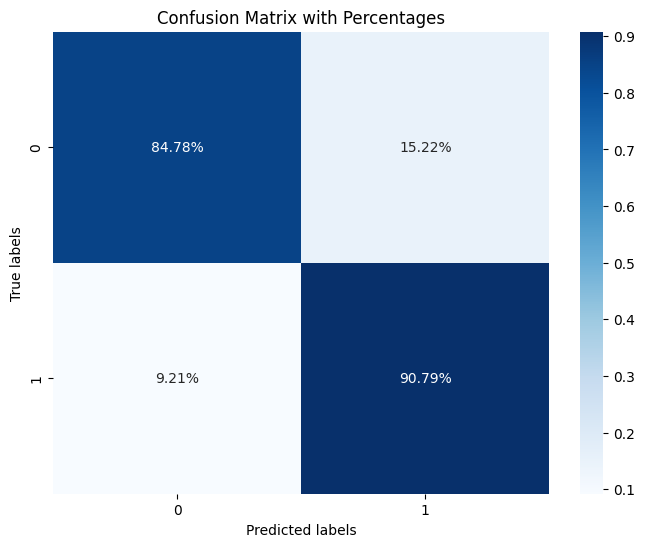

In [17]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_test_pred_entropy)

# Convert the confusion matrix to percentage
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=True, fmt=".2%", cmap='Blues', xticklabels=True, yticklabels=True)
plt.title('Confusion Matrix with Percentages')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

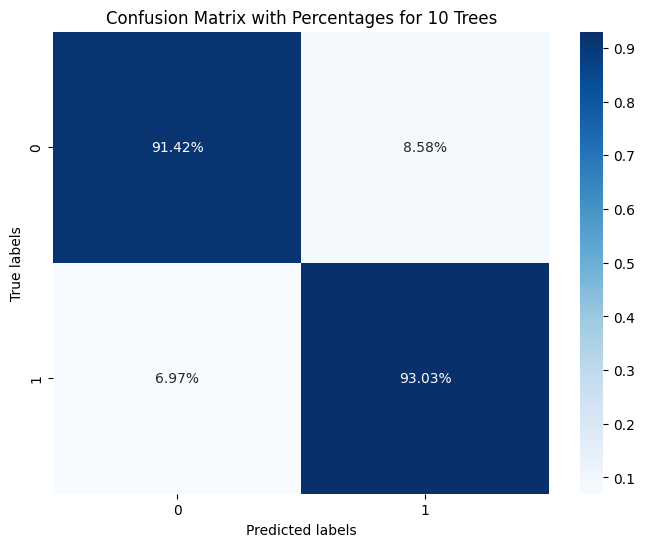

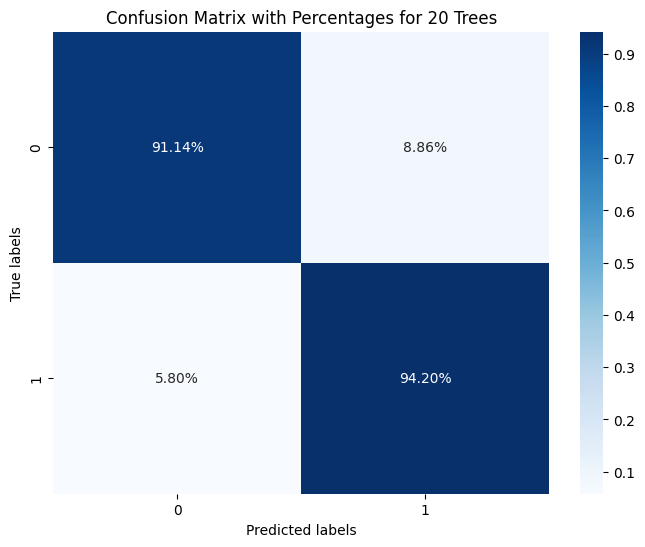

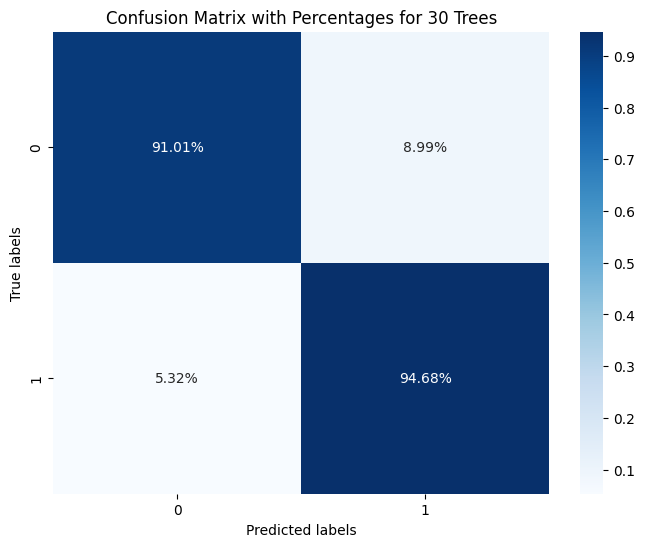

Results for 10 Trees:
Training Error: 0.0031012677377386666
Testing Error: 0.07775626285852599
Training Accuracy: 0.9968987322622613
Testing Accuracy: 0.922243737141474
Classification Report:               precision    recall  f1-score   support

         0.0       0.93      0.91      0.92      8263
         1.0       0.92      0.93      0.92      8263

    accuracy                           0.92     16526
   macro avg       0.92      0.92      0.92     16526
weighted avg       0.92      0.92      0.92     16526

--------------------------------------------------
Results for 20 Trees:
Training Error: 0.0009530725242806737
Testing Error: 0.07327847028924117
Training Accuracy: 0.9990469274757193
Testing Accuracy: 0.9267215297107588
Classification Report:               precision    recall  f1-score   support

         0.0       0.94      0.91      0.93      8263
         1.0       0.91      0.94      0.93      8263

    accuracy                           0.93     16526
   macro avg       

In [18]:
# Number of trees to explore
n_estimators_list = [10, 20, 30]

# Initialize a dictionary to store metrics
results = {n: {} for n in n_estimators_list}

# Loop through each number of trees
for n_estimators in n_estimators_list:
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf.fit(X_train_scaled, y_train)

    # Predictions
    y_train_pred_rf = rf.predict(X_train_scaled)
    y_test_pred_rf = rf.predict(X_test_scaled)

    # Metrics
    results[n_estimators]['Training Error'] = 1 - accuracy_score(y_train, y_train_pred_rf)
    results[n_estimators]['Testing Error'] = 1 - accuracy_score(y_test, y_test_pred_rf)
    results[n_estimators]['Training Accuracy'] = accuracy_score(y_train, y_train_pred_rf)
    results[n_estimators]['Testing Accuracy'] = accuracy_score(y_test, y_test_pred_rf)
    results[n_estimators]['Classification Report'] = classification_report(y_test, y_test_pred_rf)

    # Calculate the confusion matrix and convert to percentages
    cm = confusion_matrix(y_test, y_test_pred_rf)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plotting the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percentage, annot=True, fmt=".2%", cmap='Blues')
    plt.title(f'Confusion Matrix with Percentages for {n_estimators} Trees')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

# Print results
for n_estimators, metrics in results.items():
    print(f"Results for {n_estimators} Trees:")
    for metric_name, metric_value in metrics.items():
            print(f"{metric_name}: {metric_value}")
    print("-" * 50)

In [19]:
# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_train_pred_entropy_new = model.predict(X_train_scaled)
y_test_pred_entropy_new = model.predict(X_test_scaled)

metrics = {
    'Training Error': 1 - accuracy_score(y_train, y_train_pred_entropy_new),
    'Testing Error': 1 - accuracy_score(y_test, y_test_pred_entropy_new),
    'Training Accuracy': accuracy_score(y_train, y_train_pred_entropy_new),
    'Testing Accuracy': accuracy_score(y_test, y_test_pred_entropy_new),
    'Training F1': f1_score(y_train, y_train_pred_entropy_new),
    'Testing F1': f1_score(y_test, y_test_pred_entropy_new),
    'Training AUC': roc_auc_score(y_train, y_train_pred_entropy_new),
    'Testing AUC': roc_auc_score(y_test, y_test_pred_entropy_new),
}

for metric, value in metrics.items():
    print(f"{metric}: {value}")

Training Error: 0.2842274061299205
Testing Error: 0.28397676388720805
Training Accuracy: 0.7157725938700795
Testing Accuracy: 0.716023236112792
Training F1: 0.6958295557570263
Testing F1: 0.6962656138761246
Training AUC: 0.7157725938700796
Testing AUC: 0.716023236112792


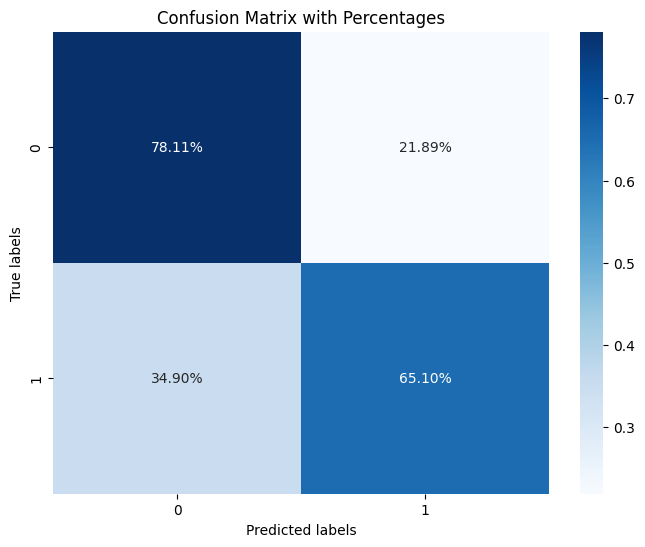

In [20]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_test_pred_entropy_new)

# Convert the confusion matrix to percentage
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=True, fmt=".2%", cmap='Blues')
plt.title('Confusion Matrix with Percentages')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

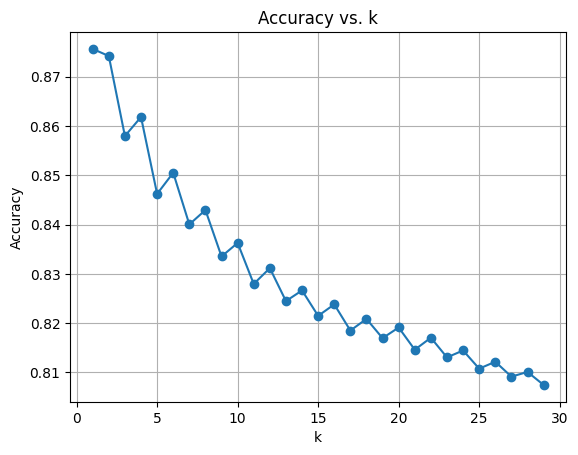

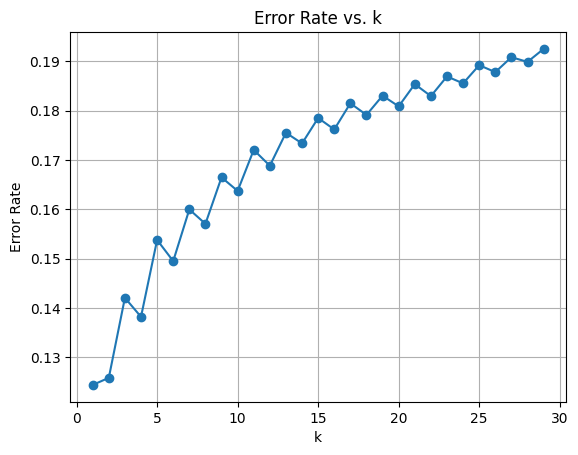

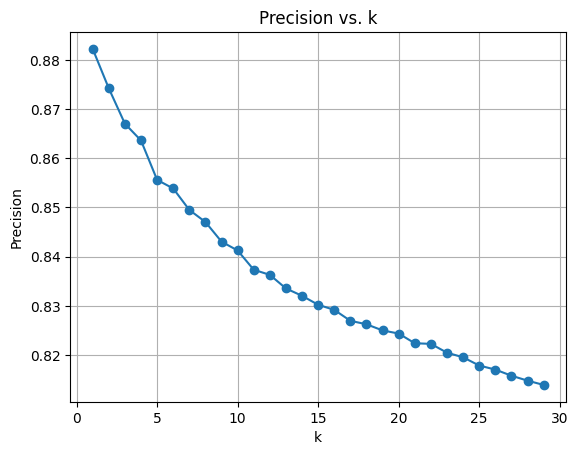

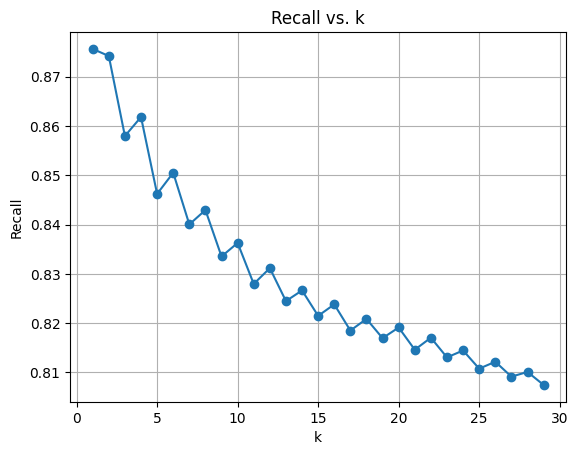

Optimal k: 1


In [21]:
# K values from 1 to 29
k_values = list(range(1, 30))

accuracy_scores = []
error_rates = []
precision_scores = []
recall_scores = []

# Perform cross-validation for each k value
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    cv_results = cross_validate(knn, X_train_scaled, y_train, cv=5, scoring=['accuracy', 'precision_macro', 'recall_macro'])

    accuracy = np.mean(cv_results['test_accuracy'])
    error = 1 - accuracy
    precision = np.mean(cv_results['test_precision_macro'])
    recall = np.mean(cv_results['test_recall_macro'])

    accuracy_scores.append(accuracy)
    error_rates.append(error)
    precision_scores.append(precision)
    recall_scores.append(recall)

# Plot accuracy vs. k
plt.plot(k_values, accuracy_scores, marker='o')
plt.title('Accuracy vs. k')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# Plot error rate vs. k
plt.plot(k_values, error_rates, marker='o')
plt.title('Error Rate vs. k')
plt.xlabel('k')
plt.ylabel('Error Rate')
plt.grid(True)
plt.show()

# Plot precision vs. k
plt.plot(k_values, precision_scores, marker='o')
plt.title('Precision vs. k')
plt.xlabel('k')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

# Plot recall vs. k
plt.plot(k_values, recall_scores, marker='o')
plt.title('Recall vs. k')
plt.xlabel('k')
plt.ylabel('Recall')
plt.grid(True)
plt.show()

optimal_k = k_values[error_rates.index(min(error_rates))]
print("Optimal k:", optimal_k)

In [22]:
# Supprot Vector Machine classifier
svm_clf = SVC(kernel='linear', C=1.0, random_state=42, probability = True)
svm_clf.fit(X_train_scaled, y_train)
y_train_pred_svm = svm_clf.predict(X_train_scaled)
y_test_pred_svm = svm_clf.predict(X_test_scaled)

metrics = {
    'Training Error': 1 - accuracy_score(y_train, y_train_pred_svm),
    'Testing Error': 1 - accuracy_score(y_test, y_test_pred_svm),
    'Training Accuracy': accuracy_score(y_train, y_train_pred_svm),
    'Testing Accuracy': accuracy_score(y_test, y_test_pred_svm),
    'Training F1': f1_score(y_train, y_train_pred_svm),
    'Testing F1': f1_score(y_test, y_test_pred_svm),
    'Training AUC': roc_auc_score(y_train, y_train_pred_svm),
    'Testing AUC': roc_auc_score(y_test, y_test_pred_svm),
}

for metric, value in metrics.items():
    print(f"{metric}: {value}")

Training Error: 0.28017306586790114
Testing Error: 0.2778651821372383
Training Accuracy: 0.7198269341320989
Testing Accuracy: 0.7221348178627617
Training F1: 0.7003430198692641
Testing F1: 0.703052250387998
Training AUC: 0.7198269341320989
Testing AUC: 0.7221348178627616


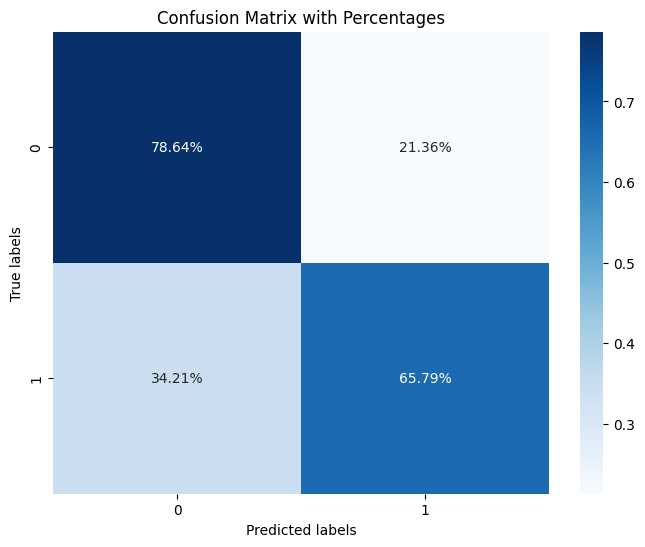

In [23]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_test_pred_svm)

# Convert the confusion matrix to percentage
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=True, fmt=".2%", cmap='Blues')
plt.title('Confusion Matrix with Percentages')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

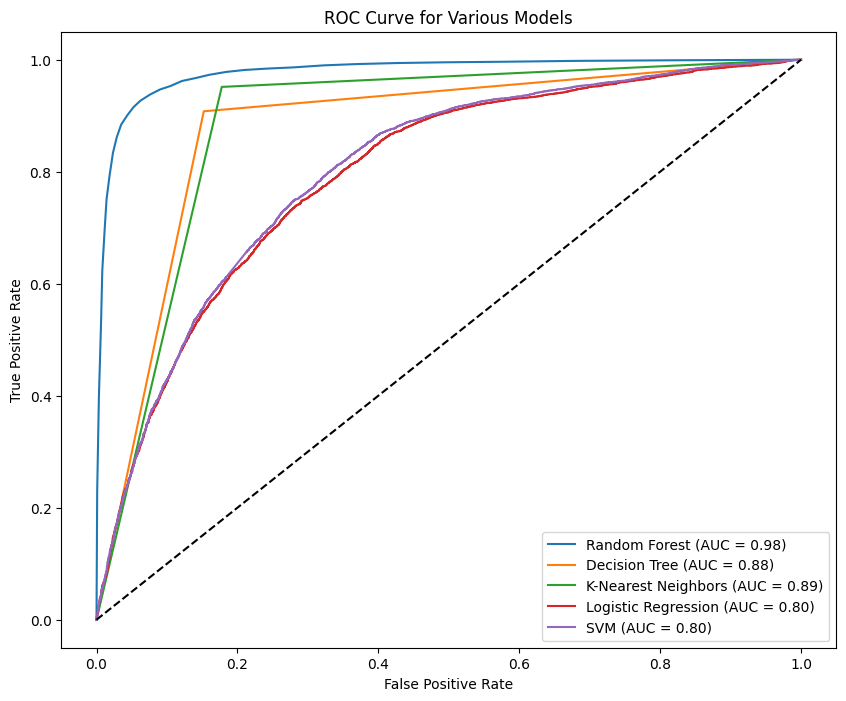

In [24]:
# Dictionary of models
models = {
    "Random Forest": rf,
    "Decision Tree": clf_entropy,
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=1),
    "Logistic Regression": model,
    "SVM": svm_clf
}

# Function to plot ROC-AUC for each model
def plot_roc_auc(models, X_train, X_test, y_train, y_test):
    plt.figure(figsize=(10, 8))

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_scores = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_scores)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, linestyle='-', label=f'{name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Various Models')
    plt.legend(loc='lower right')
    plt.show()

# Uncomment the following line to run the function with example data
plot_roc_auc(models, X_train_scaled, X_test_scaled, y_train, y_test)